***

<font color='green'>

# Project Solution: Neural Network - Part 2
### Filename: Signal.csv
### File consists of data with information on various signal tests performed:
- 1. Parameters: Various measurable signal parameters.
- 2. Signal_Quality: Final signal strength or quality

### Context: A communications equipment manufacturing company has a product which is responsible for emitting informative  signals. Company wants to build a machine learning model which can help the company to predict the equipment’s signal quality using various parameters.

### Purpose: The need is to build a classifier which can use these parameters to determine the signal strength or quality.

***
***
*Prepared by: Sauvik De*

*Date: March 1, 2021*
    
</font>

***

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import cdist, pdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# import libraries from tensorflow
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU, LeakyReLU, Reshape #Flatten, Input
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import he_uniform, he_normal, glorot_uniform, glorot_normal, RandomNormal

# set random seed
np.random.seed(1)
tf.random.set_seed(1)

import pickle

Using TensorFlow backend.


In [2]:
# Load Signal data containing signal strength / quality and various measurable signal parameters
signal = pd.read_csv('Signal.csv')

### Exploratory Data Analysis

In [3]:
print(f'The shape of the dataframe is {signal.shape}')
print('\nFirst few rows of the dataframe:')
signal.head()

The shape of the dataframe is (1599, 12)

First few rows of the dataframe:


Parameter 1  Parameter 2  Parameter 3  Parameter 4  Parameter 5  \
0          7.4         0.70         0.00          1.9        0.076   
1          7.8         0.88         0.00          2.6        0.098   
2          7.8         0.76         0.04          2.3        0.092   
3         11.2         0.28         0.56          1.9        0.075   
4          7.4         0.70         0.00          1.9        0.076   

   Parameter 6  Parameter 7  Parameter 8  Parameter 9  Parameter 10  \
0         11.0         34.0       0.9978         3.51          0.56   
1         25.0         67.0       0.9968         3.20          0.68   
2         15.0         54.0       0.9970         3.26          0.65   
3         17.0         60.0       0.9980         3.16          0.58   
4         11.0         34.0       0.9978         3.51          0.56   

   Parameter 11  Signal_Strength  
0           9.4                5  
1           9.8                5  
2           9.8                5  
3           9.8                6  
4           9.4                5

In [4]:
# Check columns and their datatypes
print(signal.info())

print("\nThere don't seem to be any missing values. Column 'Signal_Strength' is the target column.\
 Rest of 11 columns pertain to signal parameters. All the data are numerical.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
Parameter 1        1599 non-null float64
Parameter 2        1599 non-null float64
Parameter 3        1599 non-null float64
Parameter 4        1599 non-null float64
Parameter 5        1599 non-null float64
Parameter 6        1599 non-null float64
Parameter 7        1599 non-null float64
Parameter 8        1599 non-null float64
Parameter 9        1599 non-null float64
Parameter 10       1599 non-null float64
Parameter 11       1599 non-null float64
Signal_Strength    1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None

There don't seem to be any missing values. Column 'Signal_Strength' is the target column. Rest of 11 columns pertain to signal parameters. All the data are numerical.


In [5]:
print('Total number of records in the dataset:', signal.shape[0])
print('Total number of features in the dataset:', signal.shape[1]-1)

Total number of records in the dataset: 1599
Total number of features in the dataset: 11



Count of records by signal strength / quality:
5    681
6    638
7    199
4     53
8     18
3     10
Name: Signal_Strength, dtype: int64


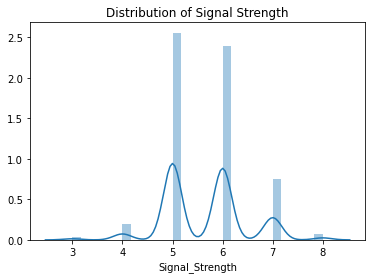

In [6]:
# Let's look at the distribution of response 'Signal_Strength' column
print("\nCount of records by signal strength / quality:")
print(signal['Signal_Strength'].value_counts())

_ = sns.distplot(signal['Signal_Strength']).set_title('Distribution of Signal Strength')

In [7]:
# Univariate analysis
# start with five-number summary and basic stats

print('\nLooking at the basic descriptive summary of attributes:')
signal.drop(columns='Signal_Strength', axis=1, inplace=False).describe().T


Looking at the basic descriptive summary of attributes:


count       mean        std      min      25%       50%  \
Parameter 1   1599.0   8.319637   1.741096  4.60000   7.1000   7.90000   
Parameter 2   1599.0   0.527821   0.179060  0.12000   0.3900   0.52000   
Parameter 3   1599.0   0.270976   0.194801  0.00000   0.0900   0.26000   
Parameter 4   1599.0   2.538806   1.409928  0.90000   1.9000   2.20000   
Parameter 5   1599.0   0.087467   0.047065  0.01200   0.0700   0.07900   
Parameter 6   1599.0  15.874922  10.460157  1.00000   7.0000  14.00000   
Parameter 7   1599.0  46.467792  32.895324  6.00000  22.0000  38.00000   
Parameter 8   1599.0   0.996747   0.001887  0.99007   0.9956   0.99675   
Parameter 9   1599.0   3.311113   0.154386  2.74000   3.2100   3.31000   
Parameter 10  1599.0   0.658149   0.169507  0.33000   0.5500   0.62000   
Parameter 11  1599.0  10.422983   1.065668  8.40000   9.5000  10.20000   

                    75%        max  
Parameter 1    9.200000   15.90000  
Parameter 2    0.640000    1.58000  
Parameter 3    0.420000    1.00000  
Parameter 4    2.600000   15.50000  
Parameter 5    0.090000    0.61100  
Parameter 6   21.000000   72.00000  
Parameter 7   62.000000  289.00000  
Parameter 8    0.997835    1.00369  
Parameter 9    3.400000    4.01000  
Parameter 10   0.730000    2.00000  
Parameter 11  11.100000   14.90000

#### Note:
- Parameter 7 and Parameter 6 have different scale vs the remaining signal features
- Parameter 1, Parameter 4 and Parameter 11 have similar scale
- Parameter 2 and Parameter 7 seem to be right skewed, as Q3 - Median exceeds Median - Q1

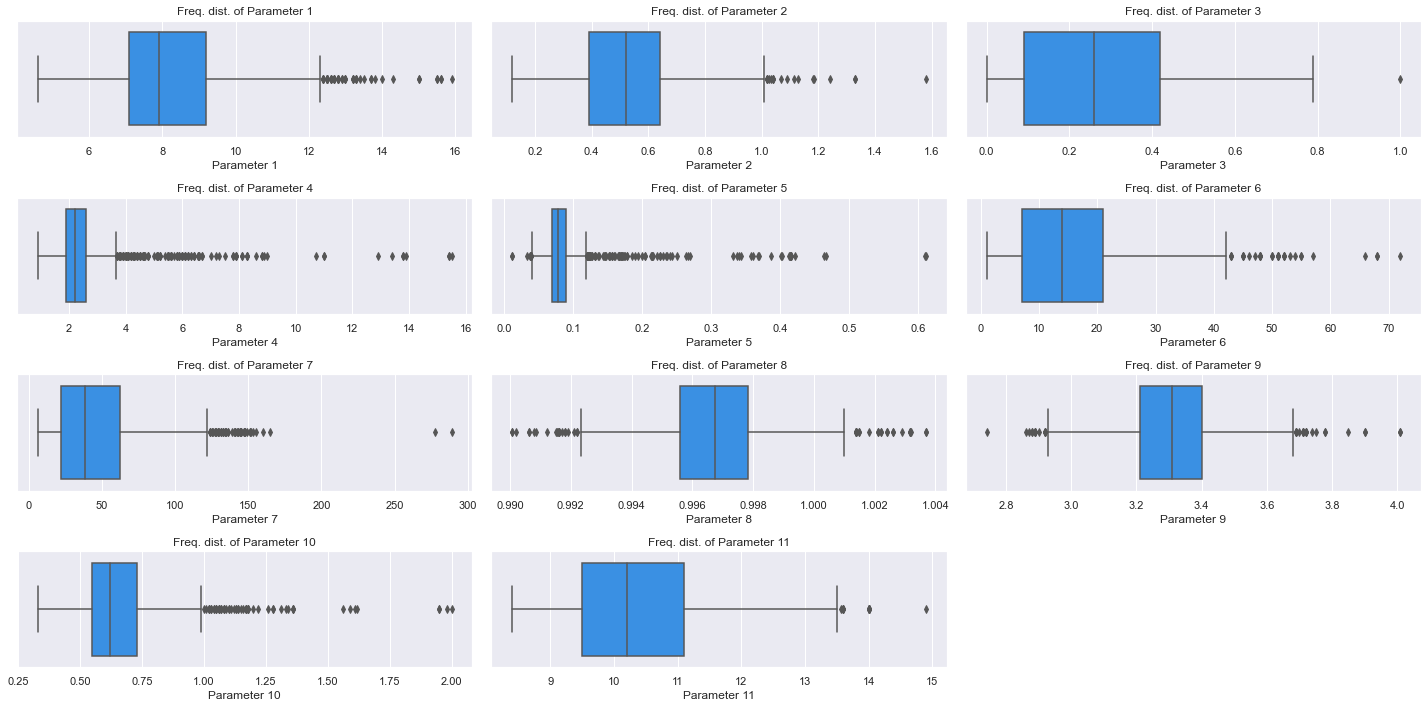

In [8]:
# Let's look at the distribution of each of the attributes in the dataset

sns.set()
fig, ax = plt.subplots(4, 3, figsize=(40,25))
plt.gcf().set_size_inches(20, 10)

cols = signal.drop(columns='Signal_Strength', axis=1).columns

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        if (i*ax.shape[1]+j) <= (len(cols)-1):
            sns.boxplot(signal[cols[i*ax.shape[1]+j]], color='dodgerblue', ax=ax[i][j]).\
            set_title("Freq. dist. of {}".format(cols[i*ax.shape[1]+j]))
        else:
            fig.delaxes(ax=ax[i][j])

plt.tight_layout()

#### Notes:
- Parameter 4, Parameter 5, Parameter 6, Parameter 7 and Parameter 10 look to be highly right skewed
- Parameter 1 and Parameter 11 look to be moderately right-skewed
- Parameter 8 and Parameter 9 look symmetric

In [9]:
signal.skew(axis=0).sort_values(ascending=False)

Parameter 5        5.680347
Parameter 4        4.540655
Parameter 10       2.428672
Parameter 7        1.515531
Parameter 6        1.250567
Parameter 1        0.982751
Parameter 11       0.860829
Parameter 2        0.671593
Parameter 3        0.318337
Signal_Strength    0.217802
Parameter 9        0.193683
Parameter 8        0.071288
dtype: float64

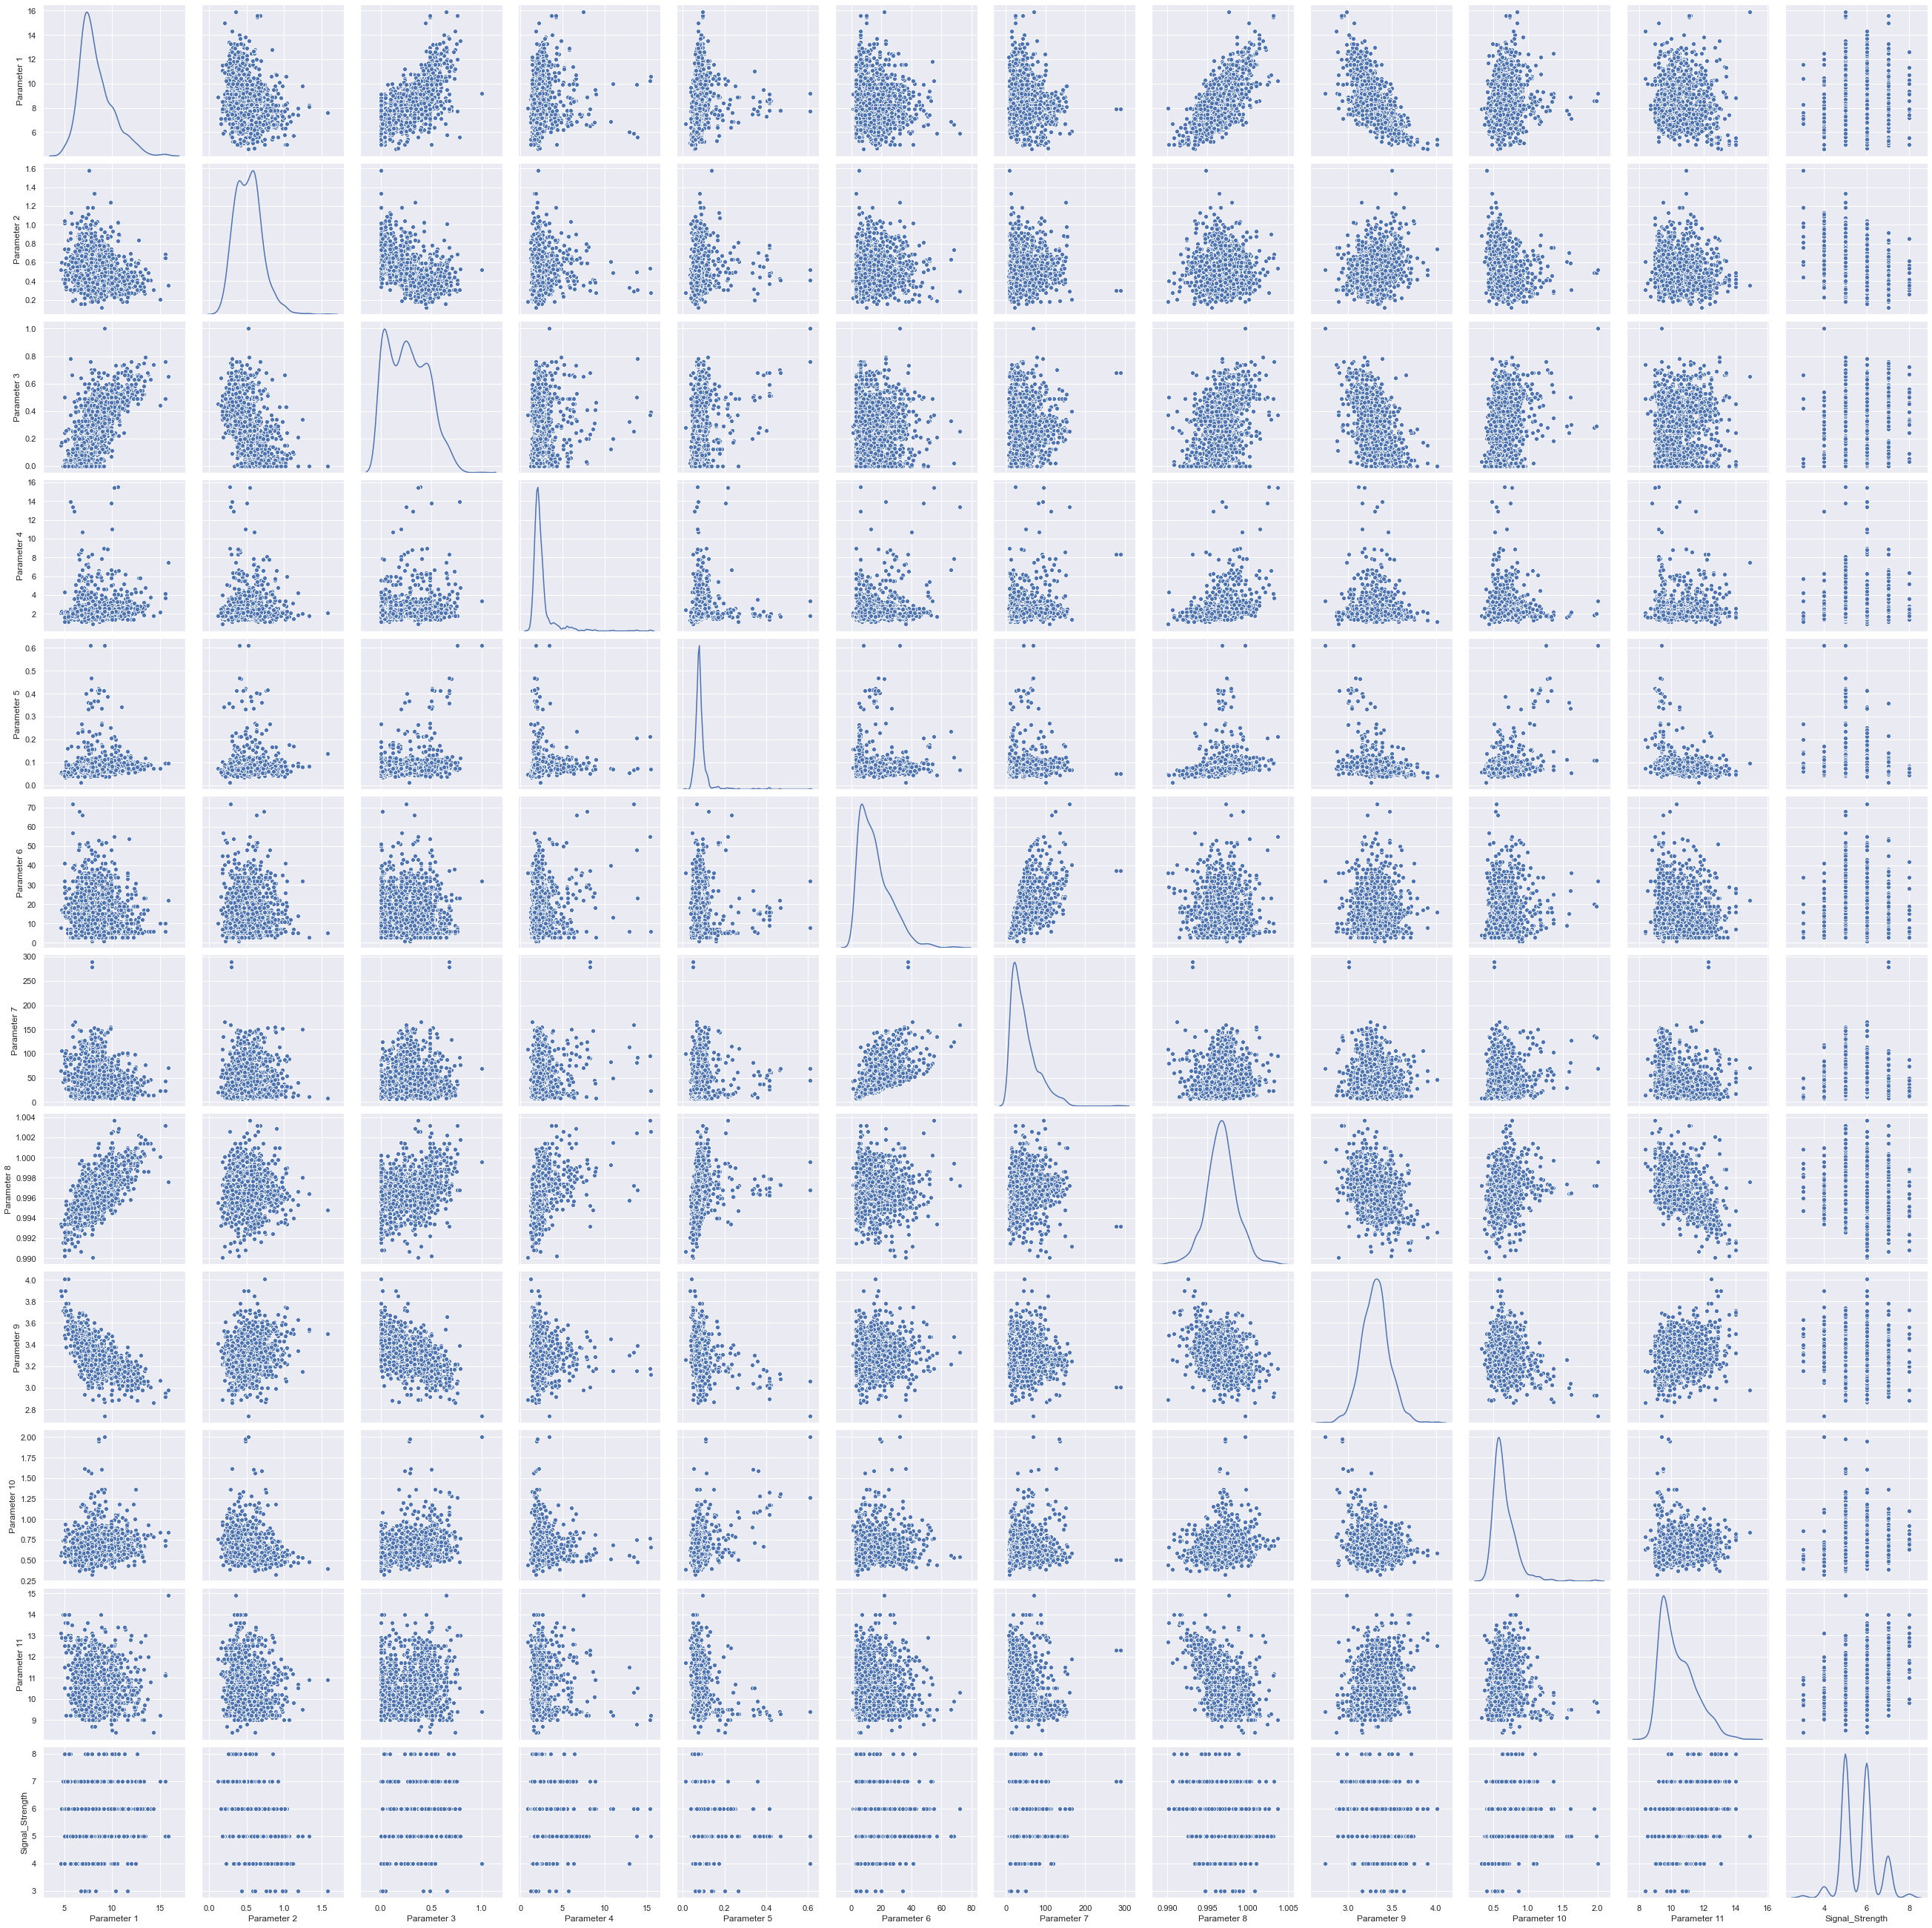

In [226]:
# Bivariate analysis
# Let's look at the attributes in a bi-variate way: 1) scatter plot, 2) correlation matrix

_ = sns.pairplot(data=signal, diag_kind='kde', palette='husl', height=3, plot_kws={'edgecolor':'white'}, \
                 diag_kws={'shade':False})

#### Looking at the above bi-variate scatterplots and univariate KDE plots, below are a few findings:
- Parameter 1 is correlated with Parameter 3 (positively), Parameter 8 (positively) and Parameter 9 (negatively)
- Parameter 6 is positively correlated with Parameter 7
- Parameter 8 is negatively correlated with both Parameter 9 and Parameter 11
- Parameters 1, 4, 5, 6, 10 and 11 have longer tail towards right indicating right skewness
- Parameter 2 and Parameter 3 seem to have multiple peaks (2 for Parameter 2 and 3 for Parameter 3) while looking at the KDE
- Smaller values of Signal Strength is generally associated with higher values of Parameter 2
- Higher values of Signal Strength is generally associated with higher values of Parameter 11
- From the KDE plots, Parameter 8 and Parameter 9 seem to be closely symmetric while the rests seem to be more right skewed
- Parameter 2 does seem to have 2 peaks indicating potential present of 2 groups / clusters
- Parameter 3 does seem to have 3 peaks indicating potential present of 3 groups / clusters

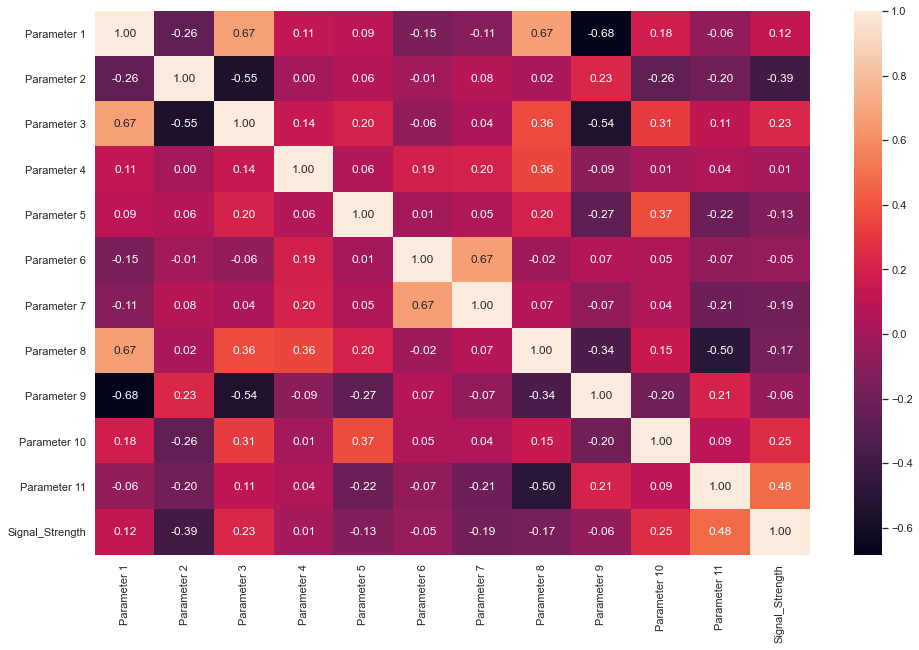

In [10]:
plt.figure(figsize=(16,10))
_ = sns.heatmap(signal.corr(), annot=True, fmt='.2f')

#### Note:
- Similar findings as in pairplot above
- Signal_Strength is mostly correlated with Parameter 2 (negatively) and Parameter 11 (positively)

In [11]:
# Segregate feature and response
X = signal.drop(columns='Signal_Strength', axis=1, inplace=False)
y = signal['Signal_Strength']

#### Thoughts:
- Parameters 2 and 3 seem to have a few peaks - we can look at clustering technique if there are some groupings among features.
- We don't have any qualitative information about Parameters. Since there is a presence of certain amount of multicolinearity among a few features (Parameters), we may want to consider PCA to see if we can combine certain features to have both enhanced signal-to-noise ratio and reduction in dimension of feature space.
- As noted earlier, since the scales are different across features, we should perform feature normalization prior to proceeding with PCA

In [12]:
X_sc = StandardScaler().fit_transform(X)

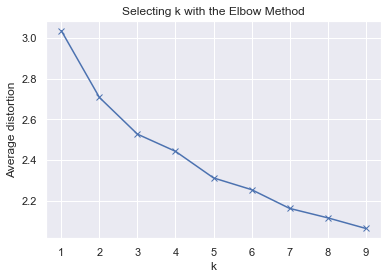

In [13]:
# Finding optimal no. of clusters
clusters = range(1,10)
meanDistortions=[]

# compute average within cluster variance for each no. of clusters (K)
for k in clusters:
    mdl = KMeans(n_clusters=k, random_state=1)
    mdl.fit(X_sc)
    prediction = mdl.predict(X_sc)
    meanDistortions.append(sum(np.min(cdist(X_sc, mdl.cluster_centers_, 'euclidean'), axis=1)) / X_sc.shape[0])

plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
_ = plt.title('Selecting k with the Elbow Method')

- We don't find any elbow using K-Means to come up with discernible cluster in feature space
- We can also try with Hierarchical clustering approach

In [14]:
# Let's try with Hierarchical clustering
# The advantage of hierarchical clustering over K-means clustering is 
# hierarchical clustering can find further sub-clusters within clusters in tree-like fashion (parent-child way)
# enabling finding hidden clusters in the data at a a granular level.
# While k-means clustering is flat or non-hierarchical clustering technique.

# Compute cophenetic correlation coefficient using different linkage methods of Agglomerative Hierarchical clustering
for typ in ['single', 'complete', 'average', 'ward']:
    L = linkage(X_sc, method=typ, metric='euclidean')
    c, coph_dists = cophenet(L , pdist(X_sc))
    print('Linkage:', typ, '-> cophenetic correlation =', c)

print('\nAverage linkage seems to produce max cophenetic correlation. Single linkage is second best.')

Linkage: single -> cophenetic correlation = 0.7588096971509067
Linkage: complete -> cophenetic correlation = 0.5338987916558153
Linkage: average -> cophenetic correlation = 0.802914300827252
Linkage: ward -> cophenetic correlation = 0.3857740414742734

Average linkage seems to produce max cophenetic correlation. Single linkage is second best.


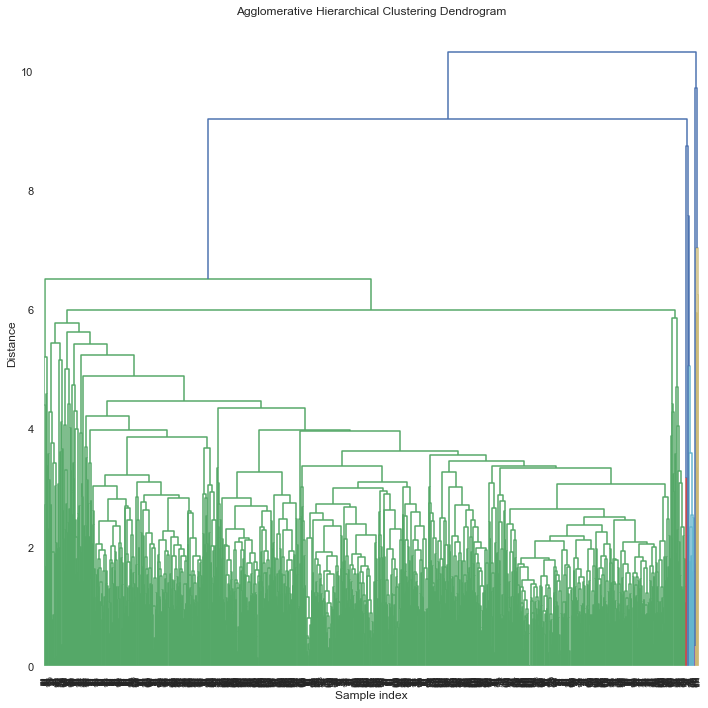

In [232]:
# we use Average linkage to construct Agglomerative Hierarchical clustering

L = linkage(X_sc, method='average', metric='euclidean')
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(L)
plt.tight_layout()

- There does not seem to have any genuine cluster present in the feature space
- Let's start with PCA next

In [15]:
# Let's split data into train and test to start with ...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1279, 11), (320, 11), (1279,), (320,))

In [16]:
# normalize data
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc  = sc.transform(X_test)

In [17]:
# Apply PCA

# Calculate covariance matrix of scaled features
cov_matrix = np.cov(X_train_sc.T)

# Compute Eigen values and Eigen vectors of the covariance matrix
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Sort Eigen values in descending order and calculate cumulative proportion of variances of eigen vectors
# The higher the eigen value, the more information content is in the corresponding eigen vector

tot_var = sum(eig_vals)
var_exp = [ (i/tot_var) * 100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

print('\nVariance explained by individual principal components:\n', var_exp)
print('\nCumulative variance explained by principal components:\n', cum_var_exp)


Variance explained by individual principal components:
 [28.56187334283129, 17.424375046840414, 14.352036163597296, 10.904221837091752, 8.644287772004331, 5.778311947532564, 5.305126544200292, 3.7271596412161627, 3.114110497138985, 1.667729115146049, 0.5207680924008791]

Cumulative variance explained by principal components:
 [ 28.56187334  45.98624839  60.33828455  71.24250639  79.88679416
  85.66510611  90.97023265  94.6973923   97.81150279  99.47923191
 100.        ]


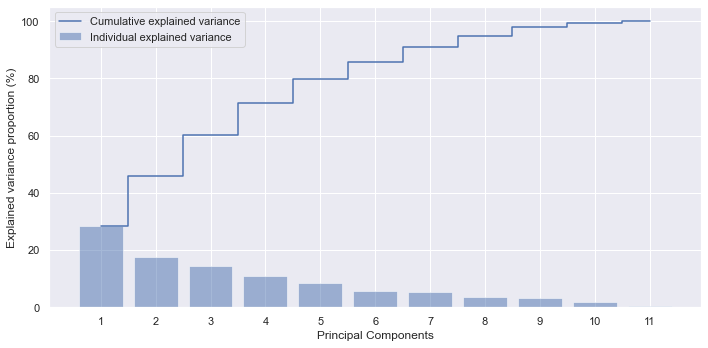

In [18]:
# Visual representation of contribution to explaining variability by principal components

plt.figure(figsize=(10,5))
plt.bar(range(1, eig_vals.size+1), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, eig_vals.size+1), cum_var_exp, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance proportion (%)')
plt.xlabel('Principal Components')
plt.xticks(ticks=range(1,eig_vals.size+1), labels=range(1,eig_vals.size+1))
plt.legend(loc='best')
plt.tight_layout()

- Looking at the contribution to explaining variability in feature space, we may want to consider first 8 components capturing about 95% of variability

In [19]:
# Compute projected feature space on a reduced dimension

# Using first 8 PCs as they cover almost 95% of variability in feature space
pca = PCA(n_components=8)
X_train_proj = pca.fit_transform(X_train_sc)
X_test_proj  = pca.transform(X_test_sc)

In [20]:
print('Shape of projected training feature space:', X_train_proj.shape)
print('Shape of projected test feature space:', X_test_proj.shape)
p = X_train_proj.shape[1]
print('The dimension of feature space reduced to', p, 'using PCA technique')

Shape of projected training feature space: (1279, 8)
Shape of projected test feature space: (320, 8)
The dimension of feature space reduced to 8 using PCA technique


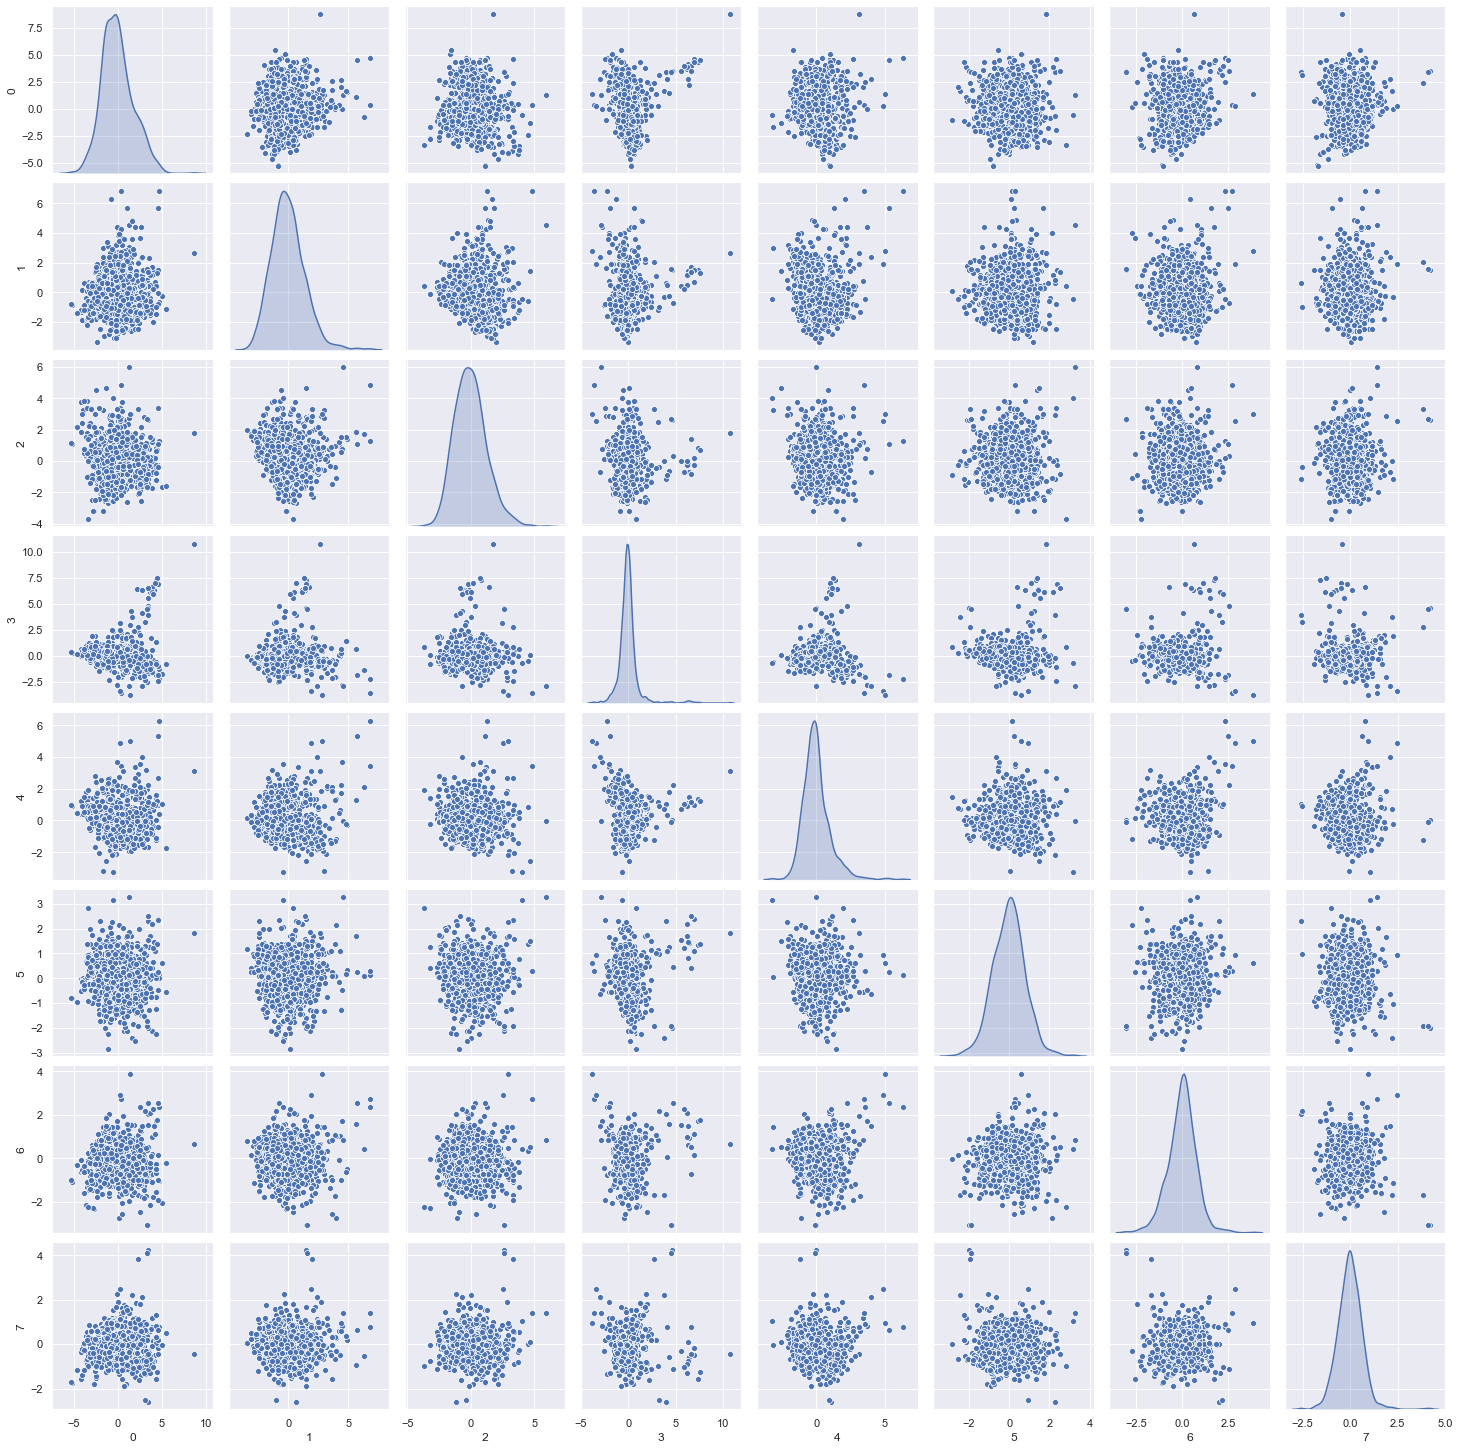

In [21]:
# Let's quickly look at the effect of PCA on features in reduced dimension
_ = sns.pairplot(pd.DataFrame(X_train_proj), diag_kind='kde')

- As we can see, there is hardly any correlation among the first 8 principal components which is one goal for applying PCA on highly correlated set of features.
- We will continue to use this "reduced" feature space for further prediction in signal strength / quality
- To predict signal strength, we can build classifier using "reduced" feature set as input in Neural Network framework 

- For classification model, we will first create one-hot-encoded class vector

In [22]:
# unique labels of response column
print(y_train.unique())
print(y_test.unique())

[6 5 7 4 8 3]
[5 6 7 4 3 8]


In [23]:
# to apply One-Hot-Encoding, we first shift class labels to start from 0
y_train_sh = (y_train - y_train.min())
y_test_sh  = (y_test - y_test.min())

In [24]:
# One-Hot-Encode target column for signal strength 
y_train_enc = tf.keras.utils.to_categorical(y_train_sh, num_classes=y_train.nunique())
y_test_enc  = tf.keras.utils.to_categorical(y_test_sh, num_classes=y_test.nunique())

- We will continue to use Principal component based "reduced" feature space for further prediction in signal strength / quality
- To predict signal strength, we can build classifier using "reduced" feature set as input to Neural Network framework
- For Neural Network, we have 8 predictors; so let's start with a network having 4 hidden layers (~50% of input shape)
- Start with Sigmoid activation in hidden layers and Softmax activation in the output layer 

In [25]:
# Step 1: Design Neural Network classifier

# Initialize model
model = Sequential()

# Input layer
model.add(tf.keras.Input(shape=(p)))

# Normalize input data
#model.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model.add(Dense(256, activation='sigmoid', kernel_initializer=glorot_uniform(seed=1), name='HL1'))
model.add(Dropout(0.10))

model.add(Dense(128, activation='sigmoid', kernel_initializer=glorot_uniform(seed=1), name='HL2'))
model.add(Dropout(0.10))

model.add(Dense(64, activation='sigmoid', kernel_initializer=glorot_uniform(seed=1), name='HL3'))
model.add(Dropout(0.05))

model.add(Dense(32, activation='sigmoid', kernel_initializer=glorot_uniform(seed=1), name='HL4'))
model.add(Dropout(0.05))

# Output Layer
model.add(Dense(y_train.nunique(), activation='softmax', name='Output'))

# Step 2: Compile model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
hist = model.fit(X_train_proj, y_train_enc, batch_size=64, epochs=2000, verbose=1, 
                 validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/2000
1279/1279 [==============================] - 0s 380us/sample - loss: 1.9043 - accuracy: 0.1188 - val_loss: 1.5374 - val_accuracy: 0.4375
Epoch 2/2000
1279/1279 [==============================] - 0s 48us/sample - loss: 1.4290 - accuracy: 0.4159 - val_loss: 1.2901 - val_accuracy: 0.4375
Epoch 3/2000
1279/1279 [==============================] - 0s 63us/sample - loss: 1.2984 - accuracy: 0.4113 - val_loss: 1.2176 - val_accuracy: 0.4375
Epoch 4/2000
1279/1279 [==============================] - 0s 62us/sample - loss: 1.2533 - accuracy: 0.4120 - val_loss: 1.1884 - val_accuracy: 0.4375
Epoch 5/2000
1279/1279 [==============================] - ETA: 0s - loss: 1.3349 - accuracy: 0.39 - 0s 51us/sample - loss: 1.2324 - accuracy: 0.4105 - val_loss: 1.1721 - val_accuracy: 0.4375
Epoch 6/2000
1279/1279 [==============================] - 0s 50us/sample - loss: 1.2302 - accuracy: 0.4011 - val_loss: 1.1623 - val_accuracy: 0.4375
Epoch 7/2000
127

In [27]:
# Step 4: Evaluate model on test data
model.evaluate(X_test_proj, y_test_enc, batch_size=64)

320/320 [==============================] - 0s 31us/sample - loss: 0.9404 - accuracy: 0.5906


[0.9404364228248596, 0.590625]

In [28]:
# Step 5: Compute accuracy score on test data
y_pred = np.argmax(model.predict(X_test_proj), axis=1)

#print(confusion_matrix(y_test_sh, y_pred))
print(accuracy_score(y_test_sh, y_pred))

0.590625


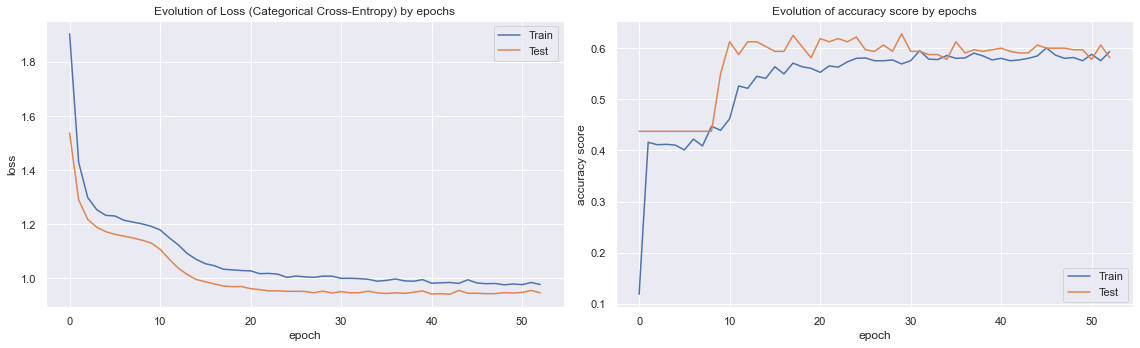

In [30]:
# Step 6: Performance evolution across iterations
h = hist
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- Test Accuracy score of 59% using sigmoid activation function with Adam optimizer
- Let's try with tanh activation function next

In [31]:
# Step 1: Design Neural Network classifier

# Initialize model
model2 = Sequential()

# Input layer
model2.add(tf.keras.Input(shape=(p)))

# Normalize input data
# model2.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model2.add(Dense(256, activation='tanh', kernel_initializer=glorot_uniform(seed=1), name='HL1'))
model2.add(Dropout(0.15))

model2.add(Dense(128, activation='tanh', kernel_initializer=glorot_uniform(seed=1), name='HL2'))
model2.add(Dropout(0.10))

model2.add(Dense(64, activation='tanh', kernel_initializer=glorot_uniform(seed=1), name='HL3'))
model2.add(Dropout(0.05))

model2.add(Dense(32, activation='tanh', kernel_initializer=glorot_uniform(seed=1), name='HL4'))
model2.add(Dropout(0.05))

# Output Layer
model2.add(Dense(y_train.nunique(), activation='softmax', name='Output'))

# Step 2: Compile model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [32]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
hist2 = model2.fit(X_train_proj, y_train_enc, batch_size=64, epochs=2000, verbose=1, 
                 validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/2000
1279/1279 [==============================] - 0s 347us/sample - loss: 1.4555 - accuracy: 0.4488 - val_loss: 1.1548 - val_accuracy: 0.5437
Epoch 2/2000
1279/1279 [==============================] - 0s 50us/sample - loss: 1.0887 - accuracy: 0.5762 - val_loss: 0.9530 - val_accuracy: 0.6219
Epoch 3/2000
1279/1279 [==============================] - 0s 60us/sample - loss: 0.9958 - accuracy: 0.5786 - val_loss: 0.9443 - val_accuracy: 0.5719
Epoch 4/2000
1279/1279 [==============================] - 0s 62us/sample - loss: 0.9739 - accuracy: 0.5809 - val_loss: 0.9175 - val_accuracy: 0.6125
Epoch 5/2000
1279/1279 [==============================] - 0s 49us/sample - loss: 0.9692 - accuracy: 0.5723 - val_loss: 0.9213 - val_accuracy: 0.6094
Epoch 6/2000
1279/1279 [==============================] - 0s 50us/sample - loss: 0.9587 - accuracy: 0.5801 - val_loss: 0.9184 - val_accuracy: 0.5750
Epoch 7/2000
1279/1279 [==============================] - 

In [33]:
# Step 4: Evaluate model on test data
model2.evaluate(X_test_proj, y_test_enc, batch_size=64)

320/320 [==============================] - 0s 31us/sample - loss: 0.9154 - accuracy: 0.6187


[0.9154056787490845, 0.61875]

In [34]:
# Step 5: Compute accuracy score on test data
y_pred2 = np.argmax(model2.predict(X_test_proj), axis=1)

#print(confusion_matrix(y_test_sh, y_pred))
print(accuracy_score(y_test_sh, y_pred2))

0.61875


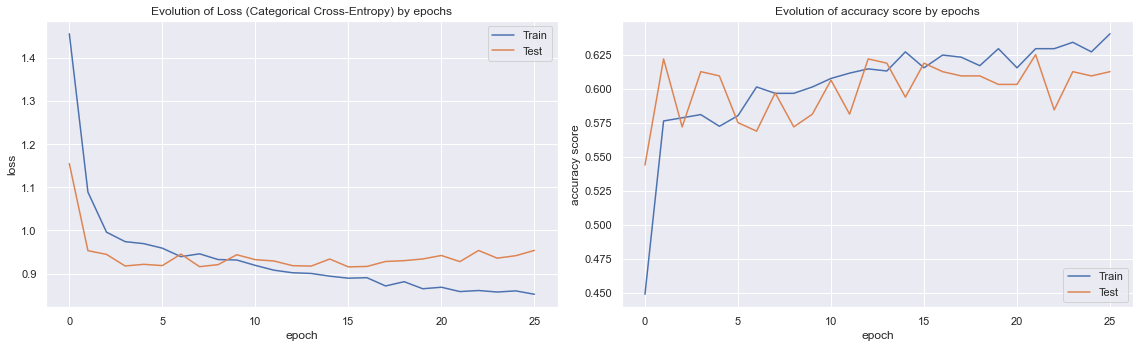

In [35]:
# Step 6: Performance evolution across iterations
h = hist2
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- Test Accuracy score of 61% using tanh activation function with Adam optimizer - slight improvement over sigmoid
- This case is somewhat an overfitting with a gap between training and test accuracy plots
- Let's try with relu activation function next

In [36]:
# Step 1: Design Neural Network classifier

# Initialize model
model3 = Sequential()

# Input layer
model3.add(tf.keras.Input(shape=(p)))

# Normalize input data
#model3.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model3.add(Dense(256, activation='relu', kernel_initializer=glorot_uniform(seed=1), name='HL1'))
model3.add(Dropout(0.15))

model3.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=1), name='HL2'))
model3.add(Dropout(0.10))

model3.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=1), name='HL3'))
model3.add(Dropout(0.05))

model3.add(Dense(32, activation='relu', kernel_initializer=glorot_uniform(seed=1), name='HL4'))
model3.add(Dropout(0.05))

# Output Layer
model3.add(Dense(y_train.nunique(), activation='softmax', name='Output'))

# Step 2: Compile model
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
hist3 = model3.fit(X_train_proj, y_train_enc, batch_size=64, epochs=2000, verbose=1, 
                 validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/2000
1279/1279 [==============================] - 0s 355us/sample - loss: 1.3822 - accuracy: 0.4253 - val_loss: 1.1162 - val_accuracy: 0.6344
Epoch 2/2000
1279/1279 [==============================] - 0s 52us/sample - loss: 1.1070 - accuracy: 0.5434 - val_loss: 1.0207 - val_accuracy: 0.5813
Epoch 3/2000
1279/1279 [==============================] - 0s 67us/sample - loss: 1.0182 - accuracy: 0.5692 - val_loss: 0.9795 - val_accuracy: 0.5656
Epoch 4/2000
1279/1279 [==============================] - 0s 58us/sample - loss: 0.9906 - accuracy: 0.5801 - val_loss: 0.9583 - val_accuracy: 0.6000
Epoch 5/2000
1279/1279 [==============================] - 0s 57us/sample - loss: 0.9713 - accuracy: 0.5919 - val_loss: 0.9572 - val_accuracy: 0.6031
Epoch 6/2000
1279/1279 [==============================] - 0s 53us/sample - loss: 0.9581 - accuracy: 0.5887 - val_loss: 0.9537 - val_accuracy: 0.5813
Epoch 7/2000
1279/1279 [==============================] - 

In [38]:
# Step 4: Evaluate model on test data
model3.evaluate(X_test_proj, y_test_enc, batch_size=64)

320/320 [==============================] - 0s 28us/sample - loss: 0.9493 - accuracy: 0.5969


[0.9493232846260071, 0.596875]

In [39]:
# Step 5: Compute accuracy score on test data
y_pred3 = np.argmax(model3.predict(X_test_proj), axis=1)

#print(confusion_matrix(y_test_sh, y_pred))
print(accuracy_score(y_test_sh, y_pred3))

0.596875


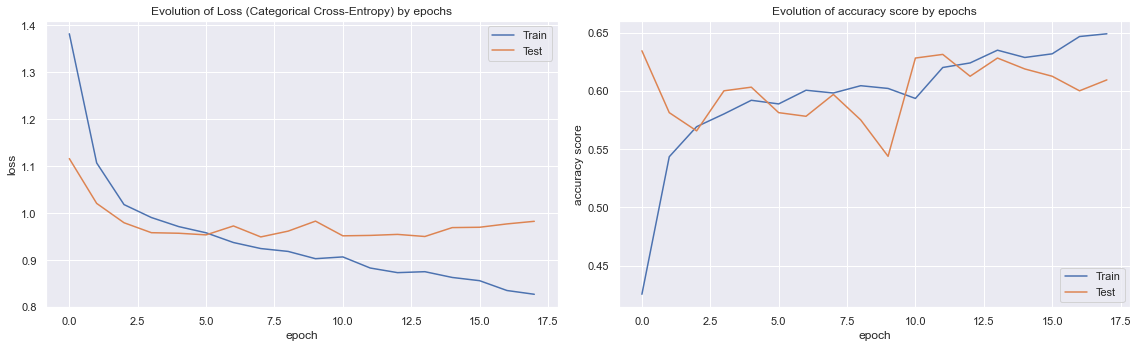

In [40]:
# Step 6: Performance evolution across iterations
h = hist3
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- Test Accuracy score of ~60% using relu activation function with Adam optimizer
- Let's try with Leaky ReLU activation function next

In [41]:
# Step 1: Design Neural Network classifier

# Initialize model
model4 = Sequential()

# Input layer
model4.add(tf.keras.Input(shape=(p)))

# Normalize input data
#model4.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model4.add(Dense(256, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL1'))
model4.add(Dropout(0.15))

model4.add(Dense(128, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL2'))
model4.add(Dropout(0.10))

model4.add(Dense(64, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL3'))
model4.add(Dropout(0.05))

model4.add(Dense(32, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL4'))
model4.add(Dropout(0.05))

# Output Layer
model4.add(Dense(y_train.nunique(), activation='softmax', name='Output'))

# Step 2: Compile model
model4.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
hist4 = model4.fit(X_train_proj, y_train_enc, batch_size=64, epochs=2000, verbose=1, 
                 validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/2000
1279/1279 [==============================] - 0s 346us/sample - loss: 1.3868 - accuracy: 0.4840 - val_loss: 1.0027 - val_accuracy: 0.6281
Epoch 2/2000
1279/1279 [==============================] - 0s 51us/sample - loss: 1.0470 - accuracy: 0.5676 - val_loss: 0.9790 - val_accuracy: 0.5906
Epoch 3/2000
1279/1279 [==============================] - 0s 65us/sample - loss: 1.0129 - accuracy: 0.5794 - val_loss: 0.9607 - val_accuracy: 0.5750
Epoch 4/2000
1279/1279 [==============================] - 0s 59us/sample - loss: 0.9894 - accuracy: 0.5653 - val_loss: 0.9564 - val_accuracy: 0.5844
Epoch 5/2000
1279/1279 [==============================] - 0s 54us/sample - loss: 0.9646 - accuracy: 0.5778 - val_loss: 0.9417 - val_accuracy: 0.6250
Epoch 6/2000
1279/1279 [==============================] - 0s 51us/sample - loss: 0.9534 - accuracy: 0.5919 - val_loss: 0.9419 - val_accuracy: 0.5750
Epoch 7/2000
1279/1279 [==============================] - 

In [43]:
# Step 4: Evaluate model on test data
model4.evaluate(X_test_proj, y_test_enc, batch_size=64)

320/320 [==============================] - 0s 25us/sample - loss: 0.9278 - accuracy: 0.6156


[0.927827000617981, 0.615625]

In [44]:
# Step 5: Compute accuracy score on test data
y_pred4 = np.argmax(model4.predict(X_test_proj), axis=1)

#print(confusion_matrix(y_test_sh, y_pred))
print(accuracy_score(y_test_sh, y_pred4))

0.615625


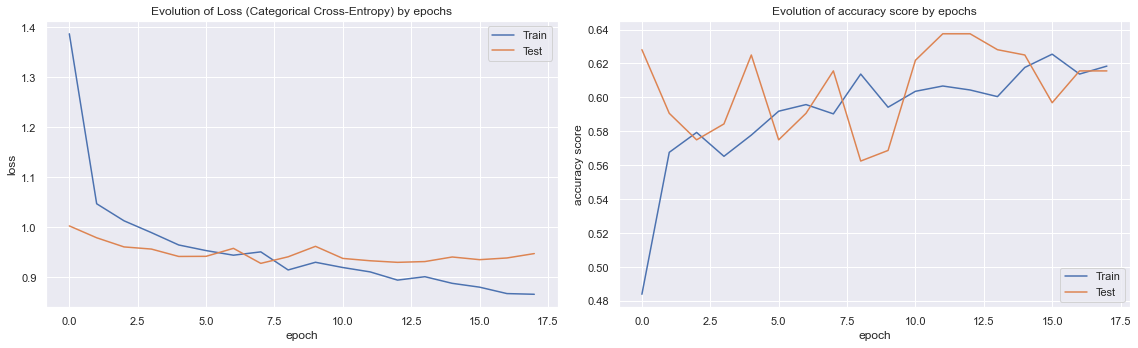

In [45]:
# Step 6: Performance evolution across iterations
h = hist4
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- Test accuracy score of 62% with LeakyreLU as activation - best so far - so stick to LeakyReLU activation in hidden layer
- The classifier is still an underfit
- We will try to overfit first - so let's increase number of hidden layers to start with

In [46]:
# Step 1: Design Neural Network classifier

# Initialize model
model5 = Sequential()

# Input layer
model5.add(tf.keras.Input(shape=(p)))

# Normalize input data
#model5.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model5.add(Dense(256, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL1'))
model5.add(Dropout(0.10))

model5.add(Dense(256, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL2'))
model5.add(Dropout(0.10))

model5.add(Dense(128, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL3'))
model5.add(Dropout(0.10))

model5.add(Dense(128, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL4'))
model5.add(Dropout(0.10))

model5.add(Dense(64, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL5'))
model5.add(Dropout(0.10))

model5.add(Dense(64, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL6'))
model5.add(Dropout(0.05))

model5.add(Dense(32, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL7'))
model5.add(Dropout(0.05))

model5.add(Dense(32, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL8'))
model5.add(Dropout(0.05))

model5.add(Dense(16, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL9'))
model5.add(Dropout(0.05))

model5.add(Dense(16, activation=LeakyReLU(), kernel_initializer=glorot_uniform(seed=1), name='HL10'))
model5.add(Dropout(0.05))

# Output Layer
model5.add(Dense(y_train.nunique(), activation='softmax', name='Output'))

# Step 2: Compile model
model5.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
#model5.compile(optimizer=Adadelta(lr=0.03), loss='categorical_crossentropy', metrics=['accuracy'])

In [47]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
hist5 = model5.fit(X_train_proj, y_train_enc, batch_size=64, epochs=2000, verbose=1, 
                 validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/2000
1279/1279 [==============================] - 1s 570us/sample - loss: 1.4055 - accuracy: 0.4402 - val_loss: 1.0496 - val_accuracy: 0.6031
Epoch 2/2000
1279/1279 [==============================] - 0s 90us/sample - loss: 1.1055 - accuracy: 0.5285 - val_loss: 1.0060 - val_accuracy: 0.5813
Epoch 3/2000
1279/1279 [==============================] - 0s 88us/sample - loss: 1.0817 - accuracy: 0.5434 - val_loss: 1.0390 - val_accuracy: 0.5656
Epoch 4/2000
1279/1279 [==============================] - 0s 87us/sample - loss: 1.0311 - accuracy: 0.5590 - val_loss: 1.0111 - val_accuracy: 0.5813
Epoch 5/2000
1279/1279 [==============================] - 0s 95us/sample - loss: 1.0421 - accuracy: 0.5473 - val_loss: 0.9470 - val_accuracy: 0.5969
Epoch 6/2000
1279/1279 [==============================] - ETA: 0s - loss: 0.9247 - accuracy: 0.56 - ETA: 0s - loss: 1.0046 - accuracy: 0.56 - 0s 94us/sample - loss: 1.0166 - accuracy: 0.5567 - val_loss: 1.02

In [48]:
# Step 4: Evaluate model on test data
model5.evaluate(X_test_proj, y_test_enc, batch_size=64)

320/320 [==============================] - 0s 38us/sample - loss: 0.9146 - accuracy: 0.6062


[0.9145678639411926, 0.60625]

In [50]:
# Step 5: Compute accuracy score on test data
y_pred5 = np.argmax(model5.predict(X_test_proj), axis=1)

#print(confusion_matrix(y_test_sh, y_pred))
print(accuracy_score(y_test_sh, y_pred5))

0.60625


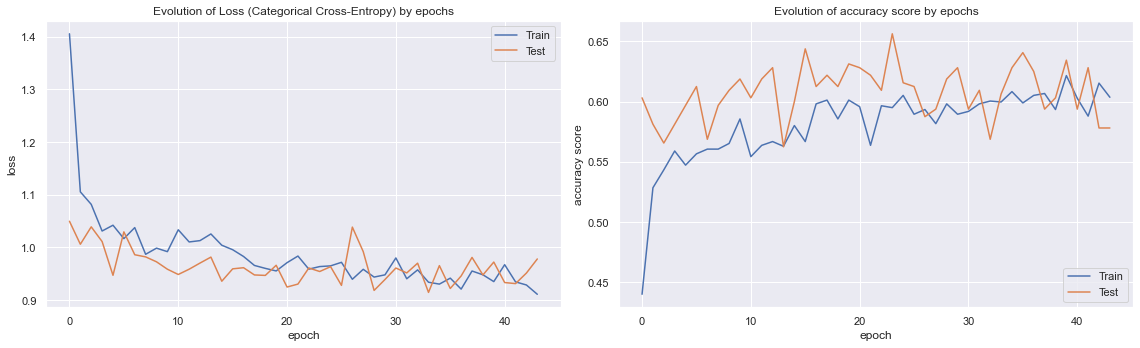

In [52]:
# Step 6: Performance evolution across iterations
h = hist5
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- Even with deeper Neural Network, the model still provides an accuracy of around 61%
- We will try to tune hyperparameters for the best accuracy

In [59]:
def MakeGenericModel (numFeatures, hyperP):
    try:
        modelH = Sequential()
        NumNetworkLayers = hyperP["NumNetworkLayers"]
        act = hyperP[1][2]
        init = hyperP[1][3]
        modelH.add(Dense(hyperP[1][1], activation=act, input_shape=(numFeatures,), kernel_initializer= init))
        for i in range(2, NumNetworkLayers+1):
            l = hyperP[i]
            if l[0] == "Dense":
                init = l[3]
                modelH.add(Dense(l[1], activation=l[2], kernel_initializer=init))   
            elif l[0] == "dropout":
                modelH.add(Dropout(l[1]))
            elif l[0] == "BN":
                modelH.add(BatchNormalization())
            else:
                raise (Exception ("Unknown type of layer encountered in layer {}".format(l))) 
            
        lastLayer = hyperP["FinalLayer"]
        if lastLayer[0] == "Dense":
            modelH.add(tf.keras.layers.Dense(lastLayer[1], activation=lastLayer[2], kernel_initializer =lastLayer[3]))

        if hyperP["opt"] == "SGD":
            opt = SGD(lr=hyperP["lr"], decay=1e-6, momentum=0.9, nesterov=True)
        else:
            opt = hyperP["opt"](hyperP["lr"])
        modelH.compile(optimizer=opt, 
                  loss= hyperP["loss"],
                  metrics=[hyperP["metrics"]]
                           )
        print ("Model Created")
        #modelH.summary()
    except Exception as ke:
        print ("Key is not defined", ke)
        modelH = None
    finally: 
        return modelH

In [60]:
HyperParams = {
    # Training Level HyperParam
    "epochs": 1000,
    "batchSize": 120,
    "opt": Adam,
    "lr": 0.01,
    "lambda": 0,
    "metrics": "accuracy",
    # Network Level HyperParam
    "NumNetworkLayers": 20,
    1:["Dense", 256, LeakyReLU(), glorot_uniform(seed=1)],
    2:["dropout", 0.1],
    3:["Dense", 256, LeakyReLU(), glorot_uniform(seed=1)],
    4:["dropout", 0.1],
    5:["Dense", 128, LeakyReLU(), glorot_uniform(seed=1)],
    6:["dropout", 0.1],
    7:["Dense", 128, LeakyReLU(), glorot_uniform(seed=1)],
    8:["dropout", 0.1],
    9:["Dense", 64, LeakyReLU(), glorot_uniform(seed=1)],
    10:["dropout", 0.1],
    11:["Dense", 64, LeakyReLU(), glorot_uniform(seed=1)],
    12:["dropout", 0.1],
    13:["Dense", 32, LeakyReLU(), glorot_uniform(seed=1)],
    14:["dropout", 0.1],
    15:["Dense", 32, LeakyReLU(), glorot_uniform(seed=1)],
    16:["dropout", 0.1],
    17:["Dense", 16, LeakyReLU(), glorot_uniform(seed=1)],
    18:["dropout", 0.1],
    19:["Dense", 16, LeakyReLU(), glorot_uniform(seed=1)],
    20:["dropout", 0.1],
    "FinalLayer":["Dense", y_train.nunique(), "softmax", glorot_uniform(seed=1)],
    "loss": "categorical_crossentropy"
}

In [61]:
lr = [0.005, 0.007, 0.009, 0.01, 0.03]
batchsize = [32, 64, 100, 128]
opt = [Adam, SGD, Adadelta]

for i in range(len(opt)):
    for j in range(len(lr)):
        for k in range(len(batchsize)):
            print('Running with optimizer:', opt[i], ', learning rate:', lr[j], ', batch size:', batchsize[k])
    
            # reset learning_rate for optimizer
            HyperParams['opt'] = opt[i]
            HyperParams['lr'] = lr[j]
            HyperParams['batchSize'] = batchsize[k]

            # Model fitting
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min')
            mdl = MakeGenericModel(p, HyperParams)
            hist = mdl.fit(X_train_proj, y_train_enc, batch_size=HyperParams["batchSize"], epochs=HyperParams["epochs"], verbose=0, 
                             validation_data=(X_test_proj, y_test_enc), callbacks=[callback]) #callbacks=[callback, chkpt]
            
            # Evaluate model on Test data
            print('\nEvaluation on test data:')
            print(mdl.evaluate(X_test_proj, y_test_enc, batch_size=HyperParams["batchSize"]))

            # # Compute accuracy score on test data
            print('\nAccuracy score on test data:')
            print(accuracy_score(y_test_sh, np.argmax(mdl.predict(X_test_proj), axis=1)))

            print('----------------------------------\n')

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> , learning rate: 0.005 , batch size: 32
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 47us/sample - loss: 0.9119 - accuracy: 0.6344
[0.9118998169898986, 0.634375]

Accuracy score on test data:
0.634375
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> , learning rate: 0.005 , batch size: 64
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 37us/sample - loss: 0.9065 - accuracy: 0.6094
[0.9065132141113281, 0.609375]

Accuracy score on test data:
0.609375
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> , learning rate: 0.005 , batch size: 100
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 28us/sample - loss: 0.9062 - accuracy: 0.6187
[0.9062263332307339, 0.61875

Model Created

Evaluation on test data:
320/320 [==============================] - 0s 31us/sample - loss: 0.9384 - accuracy: 0.5938
[0.9383996725082397, 0.59375]

Accuracy score on test data:
0.59375
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'> , learning rate: 0.007 , batch size: 32
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 56us/sample - loss: 0.9231 - accuracy: 0.6156
[0.9230916917324066, 0.615625]

Accuracy score on test data:
0.615625
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.gradient_descent.SGD'> , learning rate: 0.007 , batch size: 64
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 41us/sample - loss: 0.9367 - accuracy: 0.5938
[0.9367066264152527, 0.59375]

Accuracy score on test data:
0.59375
----------------------------------

Running with optimizer: <c

320/320 [==============================] - 0s 34us/sample - loss: 0.9629 - accuracy: 0.5469
[0.9628698587417602, 0.546875]

Accuracy score on test data:
0.546875
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'> , learning rate: 0.007 , batch size: 100
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 34us/sample - loss: 0.9798 - accuracy: 0.5437
[0.979818619787693, 0.54375]

Accuracy score on test data:
0.54375
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.adadelta.Adadelta'> , learning rate: 0.007 , batch size: 128
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 30us/sample - loss: 0.9890 - accuracy: 0.5562
[0.9890100002288819, 0.55625]

Accuracy score on test data:
0.55625
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.ad

In [63]:
lr = [0.005, 0.007, 0.009, 0.01, 0.03]
batchsize = [32, 64, 100, 128]
opt = [RMSprop]

for i in range(len(opt)):
    for j in range(len(lr)):
        for k in range(len(batchsize)):
            print('Running with optimizer:', opt[i], ', learning rate:', lr[j], ', batch size:', batchsize[k])
    
            # reset learning_rate for optimizer
            HyperParams['opt'] = opt[i]
            HyperParams['lr'] = lr[j]
            HyperParams['batchSize'] = batchsize[k]

            # Model fitting
            callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min')
            mdl = MakeGenericModel(p, HyperParams)
            hist = mdl.fit(X_train_proj, y_train_enc, batch_size=HyperParams["batchSize"], epochs=HyperParams["epochs"], verbose=0, 
                             validation_data=(X_test_proj, y_test_enc), callbacks=[callback]) #callbacks=[callback, chkpt]
            
            # Evaluate model on Test data
            print('\nEvaluation on test data:')
            print(mdl.evaluate(X_test_proj, y_test_enc, batch_size=HyperParams["batchSize"]))

            # # Compute accuracy score on test data
            print('\nAccuracy score on test data:')
            print(accuracy_score(y_test_sh, np.argmax(mdl.predict(X_test_proj), axis=1)))

            print('----------------------------------\n')

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> , learning rate: 0.005 , batch size: 32
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 52us/sample - loss: 0.9099 - accuracy: 0.6438
[0.9098665118217468, 0.64375]

Accuracy score on test data:
0.64375
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> , learning rate: 0.005 , batch size: 64
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 34us/sample - loss: 0.9310 - accuracy: 0.6000
[0.9309645652770996, 0.6]

Accuracy score on test data:
0.6
----------------------------------

Running with optimizer: <class 'tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop'> , learning rate: 0.005 , batch size: 100
Model Created

Evaluation on test data:
320/320 [==============================] - 0s 37us/sample - loss: 0.9273 - accuracy: 0.6187
[0.9272898025810719, 0

- Looking at hyperparameter combinations, the below two models perform the best with test accuracy of ~64.69%
- Adam with learning rate 0.01 and batch size 64
- RMSprop with learning rate 0.009 and batch size 64
- Adam has slightly lesser validation loss vs RMSprop

In [155]:
# Step 1: Design Neural Network classifier

init = glorot_uniform(seed=1)

# Initialize model
model6 = Sequential()

# Input layer
model6.add(tf.keras.Input(shape=(p)))

# Normalize input data
#model6.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model6.add(Dense(256, activation=LeakyReLU(), kernel_initializer=init, name='HL1'))
model6.add(Dropout(0.10))

model6.add(Dense(256, activation=LeakyReLU(), kernel_initializer=init, name='HL2'))
model6.add(Dropout(0.10))

model6.add(Dense(128, activation=LeakyReLU(), kernel_initializer=init, name='HL3'))
model6.add(Dropout(0.10))

model6.add(Dense(128, activation=LeakyReLU(), kernel_initializer=init, name='HL4'))
model6.add(Dropout(0.10))

model6.add(Dense(64, activation=LeakyReLU(), kernel_initializer=init, name='HL5'))
model6.add(Dropout(0.10))

model6.add(Dense(64, activation=LeakyReLU(), kernel_initializer=init, name='HL6'))
model6.add(Dropout(0.10))

model6.add(Dense(32, activation=LeakyReLU(), kernel_initializer=init, name='HL7'))
model6.add(Dropout(0.10))

model6.add(Dense(32, activation=LeakyReLU(), kernel_initializer=init, name='HL8'))
model6.add(Dropout(0.10))

model6.add(Dense(16, activation=LeakyReLU(), kernel_initializer=init, name='HL9'))
model6.add(Dropout(0.10))

model6.add(Dense(16, activation=LeakyReLU(), kernel_initializer=init, name='HL10'))
model6.add(Dropout(0.10))

# Output Layer
model6.add(Dense(y_train.nunique(), activation='softmax', kernel_initializer=init, name='Output'))

# Step 2: Compile model
model6.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

In [156]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min')
hist6 = model6.fit(X_train_proj, y_train_enc, batch_size=64, epochs=1000, verbose=1, 
                   validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/1000
1279/1279 [==============================] - 2s 2ms/sample - loss: 1.4223 - accuracy: 0.4558 - val_loss: 1.0124 - val_accuracy: 0.6219
Epoch 2/1000
1279/1279 [==============================] - 0s 176us/sample - loss: 1.1208 - accuracy: 0.5106 - val_loss: 1.0246 - val_accuracy: 0.5594
Epoch 3/1000
1279/1279 [==============================] - 0s 201us/sample - loss: 1.0759 - accuracy: 0.5238 - val_loss: 0.9873 - val_accuracy: 0.6187
Epoch 4/1000
1279/1279 [==============================] - 0s 209us/sample - loss: 1.0624 - accuracy: 0.5496 - val_loss: 0.9704 - val_accuracy: 0.6156
Epoch 5/1000
1279/1279 [==============================] - 0s 296us/sample - loss: 1.0220 - accuracy: 0.5582 - val_loss: 0.9533 - val_accuracy: 0.5813
Epoch 6/1000
1279/1279 [==============================] - 0s 202us/sample - loss: 1.0130 - accuracy: 0.5575 - val_loss: 0.9895 - val_accuracy: 0.5906
Epoch 7/1000
1279/1279 [==============================]

#### Below are the accuracy scores with diffent Kernel Initializers:
- glorot_normal(seed=1): 0.625
- he_normal(seed=1): 0.6375
- he_uniform(seed=1): 0.63125
- glorot_uniform(seed=1): 0.646875

In [157]:
# Step 4: Compute accuracy score on test data
print('Confusion Matrix:')
print(confusion_matrix(y_test_sh, np.argmax(model6.predict(X_test_proj), axis=1)))
print('\nAccuracy score:', accuracy_score(y_test_sh, np.argmax(model6.predict(X_test_proj), axis=1)))

Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   0  11   2   0   0]
 [  0   0 114  26   0   0]
 [  0   0  40  93   1   0]
 [  0   0   2  28   0   0]
 [  0   0   0   2   0   0]]

Accuracy score: 0.646875


In [180]:
acc = np.empty(10)
for i in range(10):
    model6.fit(X_train_proj, y_train_enc, batch_size=64, epochs=1000, verbose=0, 
               validation_data=(X_test_proj, y_test_enc), callbacks=[callback])
    acc[i] = accuracy_score(y_test_sh, np.argmax(model6.predict(X_test_proj), axis=1))
print('Avg. accuracy score:', acc.mean())
print('SD of accuracy score:', acc.std())

Avg. accuracy score: 0.634375
SD of accuracy score: 0.01511673327805977


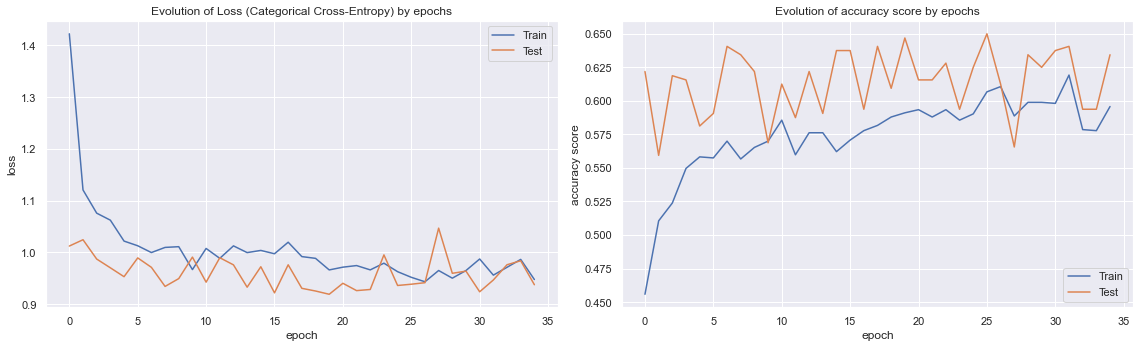

In [158]:
# Step 5: Performance evolution across iterations
h = hist6
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- softmax activation in the output layer gets us 64.69% accuracy on test data

In [169]:
# Step 1: Design Neural Network classifier

init = glorot_uniform(seed=1)

# Initialize model
model7 = Sequential()

# Input layer
model7.add(tf.keras.Input(shape=(p)))

# Normalize input data
#model7.add(BatchNormalization(input_shape=(p,)))

# Add Hidden Layers with ReLU activation; Dropout for regularization (to avoid overefitting)
model7.add(Dense(256, activation=LeakyReLU(), kernel_initializer=init, name='HL1'))
model7.add(Dropout(0.10))

model7.add(Dense(256, activation=LeakyReLU(), kernel_initializer=init, name='HL2'))
model7.add(Dropout(0.10))

model7.add(Dense(128, activation=LeakyReLU(), kernel_initializer=init, name='HL3'))
model7.add(Dropout(0.10))

model7.add(Dense(128, activation=LeakyReLU(), kernel_initializer=init, name='HL4'))
model7.add(Dropout(0.10))

model7.add(Dense(64, activation=LeakyReLU(), kernel_initializer=init, name='HL5'))
model7.add(Dropout(0.10))

model7.add(Dense(64, activation=LeakyReLU(), kernel_initializer=init, name='HL6'))
model7.add(Dropout(0.10))

model7.add(Dense(32, activation=LeakyReLU(), kernel_initializer=init, name='HL7'))
model7.add(Dropout(0.10))

model7.add(Dense(32, activation=LeakyReLU(), kernel_initializer=init, name='HL8'))
model7.add(Dropout(0.10))

model7.add(Dense(16, activation=LeakyReLU(), kernel_initializer=init, name='HL9'))
model7.add(Dropout(0.10))

model7.add(Dense(16, activation=LeakyReLU(), kernel_initializer=init, name='HL10'))
model7.add(Dropout(0.10))

# Output Layer
model7.add(Dense(y_train.nunique(), activation='softplus', kernel_initializer=init, name='Output'))

# Step 2: Compile model
model7.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
#model7.compile(optimizer=RMSprop(learning_rate=0.009), loss='categorical_crossentropy', metrics=['accuracy'])

In [170]:
# Step 3: Train model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min')
hist7 = model7.fit(X_train_proj, y_train_enc, batch_size=64, epochs=1000, verbose=1, 
                   validation_data=(X_test_proj, y_test_enc), callbacks=[callback])

Train on 1279 samples, validate on 320 samples
Epoch 1/1000
1279/1279 [==============================] - 3s 3ms/sample - loss: 1.3250 - accuracy: 0.4793 - val_loss: 1.0570 - val_accuracy: 0.5094
Epoch 2/1000
1279/1279 [==============================] - 0s 232us/sample - loss: 1.1292 - accuracy: 0.5270 - val_loss: 1.0627 - val_accuracy: 0.5750
Epoch 3/1000
1279/1279 [==============================] - 0s 227us/sample - loss: 1.0727 - accuracy: 0.5410 - val_loss: 1.0216 - val_accuracy: 0.5656
Epoch 4/1000
1279/1279 [==============================] - 0s 328us/sample - loss: 1.0808 - accuracy: 0.5403 - val_loss: 1.0249 - val_accuracy: 0.5719
Epoch 5/1000
1279/1279 [==============================] - 0s 242us/sample - loss: 1.0725 - accuracy: 0.5450 - val_loss: 1.0211 - val_accuracy: 0.5906
Epoch 6/1000
1279/1279 [==============================] - 0s 195us/sample - loss: 1.0719 - accuracy: 0.5395 - val_loss: 1.0559 - val_accuracy: 0.6313
Epoch 7/1000
1279/1279 [==============================]

In [171]:
# Step 4: Compute accuracy score on test data
print('Confusion Matrix:')
print(confusion_matrix(y_test_sh, np.argmax(model7.predict(X_test_proj), axis=1)))
print('\nAccuracy score:', accuracy_score(y_test_sh, np.argmax(model7.predict(X_test_proj), axis=1)))

Confusion Matrix:
[[  0   0   1   0   0   0]
 [  0   0   7   6   0   0]
 [  0   0 109  31   0   0]
 [  0   0  35  99   0   0]
 [  0   0   2  28   0   0]
 [  0   0   0   2   0   0]]

Accuracy score: 0.65


In [179]:
acc = np.empty(10)
for i in range(10):
    model7.fit(X_train_proj, y_train_enc, batch_size=64, epochs=1000, verbose=0, 
               validation_data=(X_test_proj, y_test_enc), callbacks=[callback])
    acc[i] = accuracy_score(y_test_sh, np.argmax(model7.predict(X_test_proj), axis=1))
print('Avg. accuracy score:', acc.mean())
print('SD of accuracy score:', acc.std())

Avg. accuracy score: 0.6206250000000001
SD of accuracy score: 0.011792476415070767


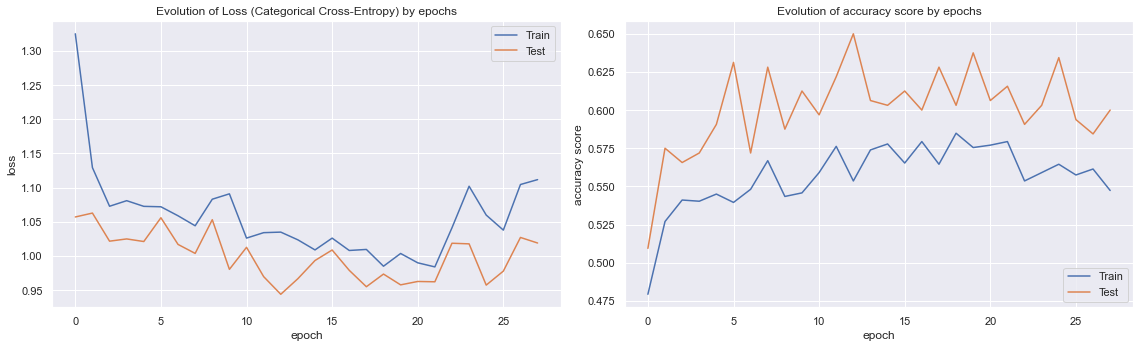

In [172]:
# Step 5: Performance evolution across iterations
h = hist7
#-----------------
plt.figure(figsize=(16,5))
# History of Loss
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('Evolution of Loss (Categorical Cross-Entropy) by epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#-----------------
# History of accuracy score
plt.subplot(1, 2, 2)
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('Evolution of accuracy score by epochs')
plt.ylabel('accuracy score')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.tight_layout()

- Using softplus activation function gets a slight improved test accuracy (65%)
- However, looking at the average test accuracy across multiple runs of fit, softmax has better test accuracy (avg:63.44%, sd:1.51%) vs softplus (avg:62%, sd:1.18%)
- We will go with softmax activation in the output layer for classifier

In [182]:
# pickle model for future use
#pickle.dump(model6, open('nn_clf_model.pkl','wb'))
#print("Model pickled")

# serialize model to JSON
JSONmodel = model6.to_json()

#save the model architecture to JSON file
with open('nn_classification_model.json', 'w') as JSONfile:
    JSONfile.write(JSONmodel)

#saving the weights of the model
model6.save_weights('nn_classification_weights.h5')

#### Conclusion
- The (Neural Network) classification model seems to perform better compared to regression model with the signal data at hand
- The accuracy score is ~64-65% on test set
- Although not high, this is roughly a descent accuracy score for classifying signal strength
- The performance could potentially be enhanced if we could have more data
- As a side note, I also computed performance of SVM classifier model on the same set of data (train/test split) ending up with test accuracy of 62%. Thus Neural Net Classifier is a touch improvement.

In [ ]:
#Qucik SVM test:
#from sklearn.svm import SVC
#clf = SVC(kernel='rbf')
#clf.fit(X_train_proj, y_train)
#accuracy_score(y_test, clf.predict(X_test_proj)) #0.621875

## <center><font color='green'>*******End of Project Solution*******</font></center>